In [75]:
# Kirjastot

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.preprocessing import StandardScaler

In [76]:
# Datan lataaminen ja tarkastaminen
df = pd.read_csv('muokattu_twitter_dataset.csv')

df.head()

,ID,Date,Query,Username,Comment
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [77]:
# Valitaan tekstidata (Comments-sarake)
comments = df['Comment']

# Muunnetaan tekstidata numeeriseksi TF-IDF-vektorisoinnilla
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(comments)

In [78]:
# Määritetään klusterien määrä (esimerkiksi 3: positiivinen, neutraali, negatiivinen)
k = 3

# K-means-algoritmin soveltaminen
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Lisätään klusteritieto dataan
df['Cluster'] = kmeans.labels_

# Näytetään muutamia rivejä klusteritiedolla
df[['Comment', 'Cluster']].head()



,Comment,Cluster
0,is upset that he can't update his Facebook by ...,0
1,@Kenichan I dived many times for the ball. Man...,0
2,my whole body feels itchy and like its on fire,1
3,"@nationwideclass no, it's not behaving at all....",0
4,@Kwesidei not the whole crew,0


In [79]:
# Tarkastellaan, kuinka monta viestiä kuuluu kuhunkin klusteriin
print(df.groupby('Cluster').size())

# Katsotaan esimerkkiviestejä jokaisesta klusterista
for cluster in range(k):
    print(f"\nCluster {cluster}:")
    print(df[df['Cluster'] == cluster]['Comment'].head(5).tolist())


Cluster
0    399
1     64
2     36
dtype: int64

Cluster 0:
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds', "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ", '@Kwesidei not the whole crew ', 'Need a hug ']

Cluster 1:
['my whole body feels itchy and like its on fire ', "@smarrison i would've been the first, but i didn't have a gun.    not really though, zac snyder's just a doucheclown.", "one of my friend called me, and asked to meet with her at Mid Valley today...but i've no time *sigh* ", "ok I'm sick and spent an hour sitting in the shower cause I was too sick to stand and held back the puke like a champ. BED now ", '@cocomix04 ill tell ya the story later  not a good day and ill be workin for like three more hours...']

Cluster 2:
['this week is not going as i 

In [80]:
# Klustereiden tulkinta esimerkkiviestien perusteella
cluster_names = {
    0: "Negatiivinen",
    1: "Neutraali",
    2: "Positiivinen"
}

# Lisätään klusterin nimi dataan
df['Cluster_Label'] = df['Cluster'].map(cluster_names)

# Näytetään data klusterinimen kanssa
df[['Comment', 'Cluster', 'Cluster_Label']].head()


,Comment,Cluster,Cluster_Label
0,is upset that he can't update his Facebook by ...,0,Negatiivinen
1,@Kenichan I dived many times for the ball. Man...,0,Negatiivinen
2,my whole body feels itchy and like its on fire,1,Neutraali
3,"@nationwideclass no, it's not behaving at all....",0,Negatiivinen
4,@Kwesidei not the whole crew,0,Negatiivinen


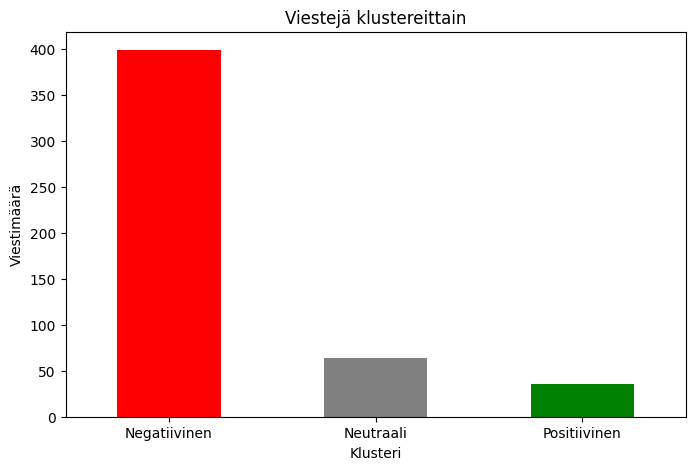

In [81]:
# Visualisoidaan klusterien jakauma
cluster_counts = df['Cluster_Label'].value_counts()

plt.figure(figsize=(8, 5))
cluster_counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title("Viestejä klustereittain")
plt.xlabel("Klusteri")
plt.ylabel("Viestimäärä")
plt.xticks(rotation=0)
plt.show()


2 käyttötapaus Viestien tulkinta

In [82]:
# Lasketaan tekstin ominaisuuksia jokaiselle viestille
df.loc[:, 'Length'] = df['Comment'].apply(len)  # Merkkien määrä
df.loc[:, 'Word_Count'] = df['Comment'].apply(lambda x: len(x.split()))  # Sanojen määrä
df.loc[:, 'Avg_Word_Length'] = df['Length'] / df['Word_Count']  # Keskimääräinen sanan pituus
df.loc[:, 'Exclamation_Count'] = df['Comment'].str.count(r'!')  # Huutomerkkejä
df.loc[:, 'Dot_Count'] = df['Comment'].str.count(r'\.')  # Pisteitä

# Lasketaan toistuvat sanat
from collections import Counter
def word_repetition(comment):
    words = comment.lower().split()
    word_counts = Counter(words)
    return sum(count - 1 for count in word_counts.values() if count > 1)

df.loc[:, 'Word_Repetition'] = df['Comment'].apply(word_repetition)

# Lasketaan lauseiden määrä (pisteet, huutomerkki, kysymysmerkki)
import re
def sentence_count(comment):
    return len(re.findall(r'[.!?]', comment))

df.loc[:, 'Sentence_Count'] = df['Comment'].apply(sentence_count)

# Lasketaan lauserakenteiden toistuvuus
def sentence_repetition(comment):
    sentences = [s.strip() for s in re.split(r'[.!?]', comment.lower()) if s.strip()]
    sentence_counts = Counter(sentences)
    return sum(count - 1 for count in sentence_counts.values() if count > 1)

df.loc[:, 'Sentence_Repetition'] = df['Comment'].apply(sentence_repetition)

# Normaaliarvoistus (tärkeää k-meansille)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = ['Length', 'Word_Count', 'Avg_Word_Length', 'Exclamation_Count', 'Dot_Count', 'Word_Repetition', 'Sentence_Count', 'Sentence_Repetition']
X_scaled = scaler.fit_transform(df[features])

# K-means-algoritmi (aluksi testataan 3 klusteria)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster_Bot'] = kmeans.fit_predict(X_scaled)

# Klusterien jakauma
print(df['Cluster_Bot'].value_counts())

# Esimerkkiviestit klustereista
for cluster in range(3):  # Kolme klusteria
    cluster_comments = df[df['Cluster_Bot'] == cluster]['Comment']
    if not cluster_comments.empty:
        print(f"\nCluster {cluster} (Esimerkkiviestit):")
        print(cluster_comments.head(5).tolist())
    else:
        print(f"\nCluster {cluster} ei sisällä viestejä.")



Cluster_Bot
0    252
2    207
1     40
Name: count, dtype: int64

Cluster 0 (Esimerkkiviestit):
['my whole body feels itchy and like its on fire ', '@Kwesidei not the whole crew ', 'Need a hug ', "@Tatiana_K nope they didn't have it ", '@twittera que me muera ? ']

Cluster 1 (Esimerkkiviestit):
['@MissXu sorry! bed time came here (GMT+1)   http://is.gd/fNge', 'Ugh....92 degrees tomorrow ', '@katortiz  Not forever... See you soon!', "Why won't you show my location?!   http://twitpic.com/2y2es", 'Strider is a sick little puppy  http://apps.facebook.com/dogbook/profile/view/5248435']

Cluster 2 (Esimerkkiviestit):
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds', "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ", "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only

In [84]:
# Klusterien tulkinta
cluster_names_bot = {
    0: "Ihmisten viestit",
    1: "Bottiviestit"
}

# Lisätään klusterinimi dataan
df['Cluster_Bot_Label'] = df['Cluster_Bot'].map(cluster_names_bot)

# Näytetään data klusterinimen kanssa
df[['Comment', 'Cluster_Bot', 'Cluster_Bot_Label']].head()

# Klusterikohtainen analyysi ja tyypillisten piirteiden tarkastelu
for cluster in range(2):
    print(f"\nAnalyysi - Cluster {cluster} ({cluster_names_bot[cluster]}):")
    cluster_data = df[df['Cluster_Bot'] == cluster]
    
    # Klusterin koko
    print(f"Klusterin koko: {cluster_data.shape[0]} viestiä")
    
    # Keskiarvot klusterin ominaisuuksista
    avg_features = cluster_data[['Length', 'Word_Count', 'Avg_Word_Length', 'Exclamation_Count', 'Dot_Count']].mean()
    print(f"Keskiarvot ominaisuuksista: \n{avg_features}")
    
    # Esimerkkiviestit
    print(f"\nEsimerkkiviestit ({cluster_names_bot[cluster]}):")
    example_comments = cluster_data['Comment'].head(5).tolist()
    for idx, comment in enumerate(example_comments):
        print(f"Esimerkki {idx+1}: {comment}")



Analyysi - Cluster 0 (Ihmisten viestit):
Klusterin koko: 252 viestiä
Keskiarvot ominaisuuksista: 
Length               51.730159
Word_Count            9.436508
Avg_Word_Length       5.496512
Exclamation_Count     0.281746
Dot_Count             0.587302
dtype: float64

Esimerkkiviestit (Ihmisten viestit):
Esimerkki 1: my whole body feels itchy and like its on fire 
Esimerkki 2: @Kwesidei not the whole crew 
Esimerkki 3: Need a hug 
Esimerkki 4: @Tatiana_K nope they didn't have it 
Esimerkki 5: @twittera que me muera ? 

Analyysi - Cluster 1 (Bottiviestit):
Klusterin koko: 40 viestiä
Keskiarvot ominaisuuksista: 
Length               44.025000
Word_Count            5.650000
Avg_Word_Length       8.708482
Exclamation_Count     1.075000
Dot_Count             2.000000
dtype: float64

Esimerkkiviestit (Bottiviestit):
Esimerkki 1: @MissXu sorry! bed time came here (GMT+1)   http://is.gd/fNge
Esimerkki 2: Ugh....92 degrees tomorrow 
Esimerkki 3: @katortiz  Not forever... See you soon!
Esimerkk

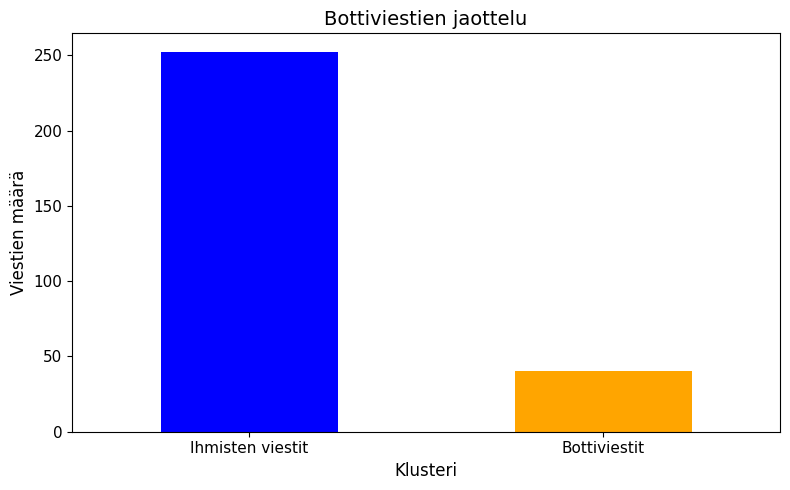

In [85]:
# Klusterien jakauman visualisointi
bot_counts = df['Cluster_Bot_Label'].value_counts()

# Visualisoidaan klusterien jakauma
plt.figure(figsize=(8, 5))

# Värit vain kahdelle klusterille
bot_counts.plot(kind='bar', color=['blue', 'orange'])  # Poistettu sekaryhmä

plt.title("Bottiviestien jaottelu", fontsize=14)
plt.xlabel("Klusteri", fontsize=12)
plt.ylabel("Viestien määrä", fontsize=12)

# Akselin nimet ja värit
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)

# Parannetaan ulkoasua
plt.tight_layout()
plt.show()


